In [2]:
import numpy as np
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.stats import kurtosis, skew, entropy

from Tutorial.Butterworth_Filters import butter_bandpass_filter, butter_highpass_filter, butter_lowpass_filter
from Tutorial.FFT_denoise import fft_denoise
from Tutorial.Wavelet_denoise import wdenoise

from Tutorial.Decomposition import eemd_decomposition

In [3]:
# try 1. butter filter + wavelet denosing / fft denosing

# idx = 7
# clean_signal = signals_clean[idx]
# try_signal = signals_train[idx]

# plt.figure()
# plt.plot(clean_signal)

# plt.figure()
# plt.plot(try_signal)

# bandpass_try_signal = butter_bandpass_filter(try_siganl, 1, 10, fs)
# plt.plot(bandpass_try_signal)
# hold_fft = 2.5e-11
# fft_try_signal = fft_denoise(try_siganl, hold_fft)
# plt.figure()
# plt.plot(fft_try_signal)

# hold_dwt = 0.45
# try_signal = butter_highpass_filter(try_signal, 0.5, fs)
# dwt_try_signal = wdenoise(try_signal, 'sym4', hold_dwt)
# plt.figure()
# plt.plot(dwt_try_signal)

In [4]:
# try 2. eemd

# idx = 92
# clean_signal = signals_clean[idx]
# try_signal = signals_train[idx]


# imfs = eemd_decomposition(standize(try_signal))

# plt.figure()
# plt.plot(standize(try_signal))
# plt.figure()
# plt.plot(standize(clean_signal))
# for imf in imfs:
#     plt.figure()
#     plt.plot(imf)

In [5]:
def standize(data):
    return (data - np.mean(data)) / np.std(data)

In [6]:
# peaks detection from Yida

def update_array(a, data_tmp):
    i = 0
    while i < len(a) - 2:
        if data_tmp[a[i]] < data_tmp[a[i + 1]] < data_tmp[a[i + 2]]:
            a = np.delete(a, i)
        elif data_tmp[a[i]] > data_tmp[a[i + 1]] > data_tmp[a[i + 2]]:
            a = np.delete(a, i + 2)
        else:
            i += 1
    return a

def get_peaks(data_tmp, duration, sampling_rate):
    max = np.max(data_tmp)
    data_tmp = data_tmp / max

    t = np.linspace(0, duration, duration * sampling_rate)
    signal = data_tmp

    peak_indices, _ = find_peaks(signal) 

    t_peaks = t[peak_indices] 
    peak_values = signal[peak_indices]  
    interpolation_func = interp1d(t_peaks, peak_values, kind='linear', bounds_error=False, fill_value=0)
    envelope = interpolation_func(t)

    peaks2, _ = find_peaks(envelope, distance=10)

    peaks2 = update_array(peaks2, data_tmp)
    if len(peaks2) % 2 != 0:
        peaks2 = np.delete(peaks2, len(peaks2) - 1)

    return peaks2

In [7]:
# features extraction from Yida

def delete_unique(a):
    mean = np.mean(a)
    std = np.std(a)
    threshold = 1
    filtered_a = a[np.abs(a - mean) <= threshold * std]

    # max_index = np.argmax(filtered_a)
    # min_index = np.argmin(filtered_a)

    # filtered_a = np.delete(filtered_a, [max_index, min_index])

    # max_index = np.argmax(filtered_a)
    # min_index = np.argmin(filtered_a)

    # filtered_a = np.delete(filtered_a, [max_index, min_index])

    return a
    # return filtered_a


def get_mag_0(peaks2, data_tmp):
    mag = data_tmp[peaks2[::2]]
    mean_mag = np.mean(mag)
    std_mag = np.std(mag)
    filtered_mag = mag[np.abs(mag-mean_mag) <= std_mag]
    return np.mean(filtered_mag)

def get_mag_1(peaks2, data_tmp):
    mag = data_tmp[peaks2[1::2]]
    mean_mag = np.mean(mag)
    std_mag = np.std(mag)
    filtered_mag = mag[np.abs(mag-mean_mag) <= std_mag]
    return np.mean(filtered_mag)

def get_features(data_tmp, peaks2):
    max = np.max(data_tmp)
    # min = np.min(data_tmp)
    data_tmp_raw = data_tmp
    data_tmp = data_tmp / max

    data_tmp = data_tmp_raw / max

    diff_12 = peaks2[1::2] - peaks2[0::2]
    diff_21 = peaks2[2::2] - peaks2[1:-1:2]
    diff_22 = peaks2[2::2] - peaks2[:-2:2]

    diff_12 = delete_unique(diff_12)
    diff_21 = delete_unique(diff_21)
    diff_22 = delete_unique(diff_22)

    m_12 = np.mean(diff_12)
    m_21 = np.mean(diff_21)
    m_22 = np.mean(diff_22)

    mag_0 = get_mag_0(peaks2, data_tmp_raw)
    mag_1 = get_mag_1(peaks2, data_tmp_raw)

    features = np.array([m_12, m_21, m_22, m_12 / m_21, mag_0, mag_1, mag_0 - mag_1, mag_0 / mag_1])

    return features




In [8]:

if __name__ == '__main__':
    fs = 100
    sampling_rate = 100
    duration = 10
    data_clean = np.load('../Data/NewTry/sim_5000_0_90_140_train.npy')
    data_train = np.load('../Data/NewTry/sim_5000_0.8_90_140_train.npy')
    data_test = np.load('../Data/NewTry/sim_5000_0.8_141_178_test.npy')

    train_len, test_len = 500, 300
    signals_train, S_train, D_train = data_train[:train_len, :1000], data_train[:train_len, -2], data_train[:train_len, -1]
    signals_test, S_test, D_test = data_test[:test_len, :1000], data_test[:test_len, -2], data_test[:test_len, -1]
    signals_clean = data_clean[:, :1000]
    HR_train = data_train[:train_len, -4]
    HR_test = data_test[:test_len, -4]

    # 先保存EEMD中第一个的结果, 2000, 1000

    imf_train_ls = []
    for cnt, signal in enumerate(signals_train):
        if cnt % 10 == 0:
            print(cnt)
        imfs = eemd_decomposition(standize(signal))
        imf_1 = imfs[0]
        imf_train_ls.append(imf_1)
        break
    # imf_train_np = np.array(imf_train_ls)

    # imf_test_ls = []
    # for cnt, signal in enumerate(signals_test):
    #     if cnt % 10 == 0:
    #         print(cnt)
    #     imf_1 = eemd_decomposition(standize(signal))[0]
    #     imf_test_ls.append(imf_1)
    # imf_test_np = np.array(imf_test_ls)


0


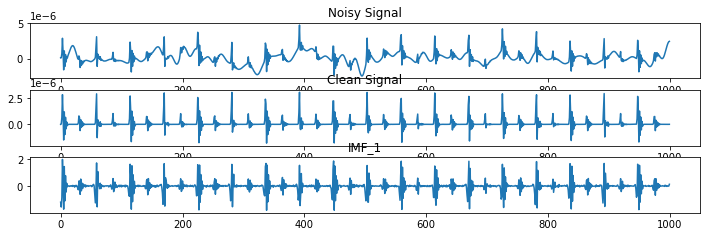

In [36]:
idx = 6
signal = signals_train[idx]
signal_clean = signals_clean[idx]

imfs = eemd_decomposition(standize(signal))

fig, axes = plt.subplots(3, 1, figsize=(12, 3.5))
axes[0].plot(signal)
axes[0].set_title('Noisy Signal')
axes[1].plot(signal_clean)
axes[1].set_title('Clean Signal')
axes[2].plot(imfs[0])
axes[2].set_title('IMF_1')

fig.savefig('../Pic/8.21/IMF_1_'+str(idx)+'.jpg', dpi=300)

In [ ]:
# draw 

# imf_train_np = np.load('../Data/NewTry/Imf_500_0.8_train.npy')

# imf_test_np = np.load('../Data/NewTry/Imf_300_0.8_test.npy')
# # imf_test_np.shape, imf_train_np.shape

# for cnt, imf in enumerate(imf_train_np):




In [15]:
imf_train_np = np.load('../Data/NewTry/Imf_500_0.8_train.npy')

imf_test_np = np.load('../Data/NewTry/Imf_300_0.8_test.npy')
imf_test_np.shape, imf_train_np.shape



def moving_average(signal):
    signal[np.abs(signal) < 0.036 * np.max(signal)] = 0

    return signal

# smoothed_imfs = []
# for imf in imf_train_np:
#     smoothed_imf = moving_average(imf)
#     smoothed_imfs.append(smoothed_imf)
#     peaks = get_peaks(smoothed_imf, duration, fs)
#     plt.figure(figsize=(12,8))
#     plt.title(str(len(peaks)))
#     plt.plot(smoothed_imf)
#     plt.scatter(peaks, smoothed_imf[peaks], color='r')
def features_idx(imf_np):
    # smoothed_imfs = []
    features = []
    idx = []
    for cnt, imf in enumerate(imf_np):
        # plot
        # fig, axes = plt.subplots(2, 1, figsize=(18,6))
        # axes[0].plot(imf)

        smoothed_imf = moving_average(imf)
        # smoothed_imfs.append(smoothed_imf)
        peaks = get_peaks(smoothed_imf, duration, fs)
        # print(cnt, len(peaks))
        if len(peaks) < 16 or len(peaks) > int(1.05* 0.35 * HR_train[cnt]) :
            # plt.figure(figsize=(8, 6))
            # plt.title(str(len(peaks)))
            # plt.plot(smoothed_imf)
            # plt.scatter(peaks, smoothed_imf[peaks], color='r')
            continue
        # plot
        # axes[1].plot(smoothed_imf)
        # axes[1].scatter(peaks, smoothed_imf[peaks], color='r')
        # axes[0].set_title('Imf_1 Before filtering')
        # axes[1].set_title('Imf_1 After filtering')
        # fig.savefig('../Pic/8.21/IMF_filtering_'+str(cnt)+'.jpg', dpi=300)

        idx.append(cnt)
        features.append(get_features(smoothed_imf, peaks))
        # if cnt > 10: 
            # break
    print(len(idx))

    return np.array(features), idx

print(imf_train_np.shape)
features_train, idx_train = features_idx(imf_train_np)
features_test, idx_test = features_idx(imf_test_np)

(500, 1000)
474
269


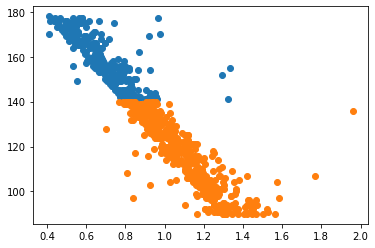

In [38]:
np.corrcoef(features_train[:, 3], S_train[idx_train])[0, 1], np.corrcoef(features_test[:, 3], S_test[idx_test])[0, 1]

features_test[features_test[:, 3] > 1.6] = 0.6
plt.scatter(features_test[:, 3], S_test[idx_test])
plt.scatter(features_train[:, 3], S_train[idx_train])


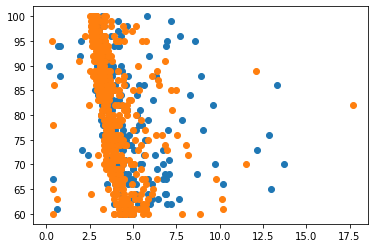

In [39]:
np.corrcoef(features_train[:, 3], S_train[idx_train])[0, 1], np.corrcoef(features_test[:, 3], S_test[idx_test])[0, 1]

# features_test[features_test[:, 3] > 1.6] = 0.6
plt.scatter(features_test[:, -1], D_test[idx_test])
plt.scatter(features_train[:, -1], D_train[idx_train])



In [43]:
def LinearRegression(input_train, label_train, input_test, label_test):
    from sklearn.linear_model import LinearRegression as LR 
    reg = LR().fit(input_train, label_train)
    yhat = reg.predict(input_test)
    return np.mean(np.abs(yhat - label_test)), yhat


mae_S, S_predict = LinearRegression(features_train[:, 3].reshape(-1, 1), S_train[idx_train], features_test[:, 3].reshape(-1, 1), S_test[idx_test])
mae_D, D_predict = LinearRegression(features_train[:, -1].reshape(-1, 1), D_train[idx_train], features_test[:, -1].reshape(-1, 1), D_test[idx_test])

Saved plot to S_0.8.png


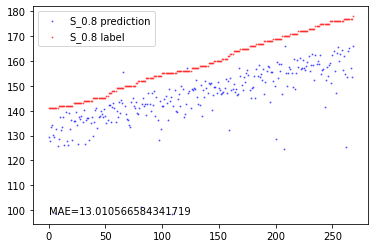

Saved plot to D_0.8.png


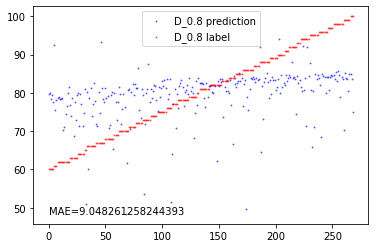

In [44]:
from utils import plot_2vectors
plot_2vectors(S_test[idx_test], np.array(S_predict), "S_0.8")
plot_2vectors(D_test[idx_test], np.array(D_predict), "D_0.8")